In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [0]:
import numpy as np
from pathlib import Path
from torchvision.datasets import CIFAR10, MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torchvision.utils as vutils
from torch import nn

In [0]:
# Setting up constants
# device
ngpu = 1

# single image
imageSize = 64
imageMean = (0.4923172 , 0.48307145, 0.4474483)
imageStd = (0.24041407, 0.23696952, 0.25565723)

# data loader
numWorkers = 1
batchSize = 16

# Network Arch
nc = 3 # Number of channels
nz = 100 # Latent vector
ngf = 128 # relates to the depth of feature maps carried through the generator
ndf = 128 # sets the depth of feature maps propagated through the discriminator

# Training
num_epochs = 10

# Adam Optimizer
lr = .005
beta1 = .5

# convention of the labeling for the real and the fake datasets
real_label = .8
fake_label = 0

In [0]:
dataFolder = Path("./data")
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [0]:
# functions 
def visual_data(batch, device):
    """
    Visualize a batch of image data
    
    Params
    --------------------------------
    batch:: a batch of images to visualize
            in numpy matrix format
            
    device:: cpu/gpu device used for computations
    """
    plt.figure(figsize=(12, 12))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], 
                                             padding=2, normalize=True).cpu(),(1,2,0)))

def load_mnist(mnistFolder, tsfms, batchSize=64, numWorkers=0):
    """
    Load, download if necessary, the CIFAR10 data and 
    return the iterable batch generator object
    
    Params
    --------------------------------
    cifarFolder:: folder to store/load the CIFAR10 data from
    tsfms:: transformations requaired to apply on data
    batchSize:: number of samples on each batch of the data
    numWorkers:: number of cpu cores used to load the data
    
    Return:
    --------------------------------
    trainLoader:: iterable training data batch generator object
    testLoader:: iterable test data batch generator object
    """
    trainData = MNIST(mnistFolder, download=True, train=True, transform=tsfms)
    trainLoader = DataLoader(trainData, batch_size=batchSize, num_workers=numWorkers)
    
    testData = MNIST(mnistFolder, download=True, train=False, transform=tsfms)   
    testLoader = DataLoader(testData, batch_size=batchSize, num_workers=numWorkers)
    
    return trainLoader, testLoader

def load_cifar10(cifarFolder, tsfms, batchSize=64, numWorkers=0):
    """
    Load, download if necessary, the CIFAR10 data and 
    return the iterable batch generator object
    
    Params
    --------------------------------
    cifarFolder:: folder to store/load the CIFAR10 data from
    tsfms:: transformations requaired to apply on data
    batchSize:: number of samples on each batch of the data
    numWorkers:: number of cpu cores used to load the data
    
    Return:
    --------------------------------
    trainLoader:: iterable training data batch generator object
    testLoader:: iterable test data batch generator object
    """
    trainData = CIFAR10(cifarFolder, download=True, train=True, transform=tsfms)
    trainLoader = DataLoader(trainData, batch_size=batchSize, num_workers=numWorkers)
    
    testData = CIFAR10(cifarFolder, download=True, train=False, transform=tsfms)   
    testLoader = DataLoader(testData, batch_size=batchSize, num_workers=numWorkers)
    
    return trainLoader, testLoader

def weights_init(m):
    """
    Custom weight initializer from the DCGAN papar
    Different from the usual way of initializing the weigths
    
    Params:
    -----------------------------------
    m:: network object
    
    -----------------------------------
    DCGAN paper arXiv:1511.06434 
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
# the generator

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [413]:
tsfms = transforms.Compose([
    transforms.Resize(imageSize), 
    transforms.ToTensor(),
    transforms.Normalize(imageMean, imageStd)
])

cifarFolder = dataFolder/"CIFAR10"

trainLoader, test_loader = load_cifar10(cifarFolder, tsfms, batchSize, numWorkers)
# trainLoader, test_loader = load_mnist(cifarFolder, tsfms, batchSize, numWorkers)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
gen = Generator(ngpu).to(device)
gen.apply(weights_init);
disc = Discriminator(ngpu).to(device)
disc.apply(weights_init);

In [0]:
# BCE loss function
criterion = nn.BCELoss()
# fixed noise z for viusalization of the progress of the training
fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)

# setup optmization 
optimizerD = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))

In [416]:
# training loop 

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

Starting Training Loop...


In [0]:
import numpy as np
dgz = 0 

bestGParams = None

In [418]:
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the trainLoader
    for i, data in enumerate(trainLoader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        disc.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label_real = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output_real = disc(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output_real, label_real)
        # Calculate gradients for D in backward pass
        
        D_x = output_real.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate fake image batch with G
        fake = gen(noise)
        label_fake = torch.full((b_size,), fake_label, device=device)
        # Classify all fake batch with D
        output_fake = disc(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output_fake, label_fake)
        # Calculate the gradients for this batch
        
        D_G_z1 = output_fake.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = .5 * (errD_real + errD_fake)

        # errD_real.backward()
        # errD_fake.backward()
        errD.backward()
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen.zero_grad()
        label = torch.full((b_size,), real_label, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disc(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        ####
        if D_G_z2 > dgz:
          bestGParams = gen.state_dict()
          dgz = D_G_z2

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainLoader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainLoader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/10][0/3125]	Loss_D: 1.0001	Loss_G: 22.1048	D(x): 0.4656	D(G(z)): 0.5614 / 0.0000
[0/10][50/3125]	Loss_D: 5.3142	Loss_G: 21.5963	D(x): 0.5213	D(G(z)): 0.3128 / 0.0018
[0/10][100/3125]	Loss_D: 7.2601	Loss_G: 9.9120	D(x): 0.4859	D(G(z)): 0.2424 / 0.0186
[0/10][150/3125]	Loss_D: 6.1138	Loss_G: 8.0344	D(x): 0.1662	D(G(z)): 0.2028 / 0.0994
[0/10][200/3125]	Loss_D: 3.1402	Loss_G: 9.4734	D(x): 0.8988	D(G(z)): 0.2618 / 0.1263
[0/10][250/3125]	Loss_D: 2.6943	Loss_G: 3.8309	D(x): 0.2971	D(G(z)): 0.3069 / 0.2221
[0/10][300/3125]	Loss_D: 0.5257	Loss_G: 2.1358	D(x): 0.5697	D(G(z)): 0.1511 / 0.1925
[0/10][350/3125]	Loss_D: 0.7021	Loss_G: 3.1426	D(x): 0.7261	D(G(z)): 0.3404 / 0.0467
[0/10][400/3125]	Loss_D: 1.1823	Loss_G: 1.9784	D(x): 0.1728	D(G(z)): 0.0290 / 0.1069
[0/10][450/3125]	Loss_D: 1.0837	Loss_G: 1.7180	D(x): 0.3759	D(G(z)): 0.5772 / 0.1891
[0/10][500/3125]	Loss_D: 0.4937	Loss_G: 2.2411	D(x): 0.6671	D(G(z)): 0.2695 / 0.0807
[0/10][550/3125]	Loss_D: 0.7380	Loss_G: 4.5136	D(x): 0.7003	D(G(z)

KeyboardInterrupt: ignored

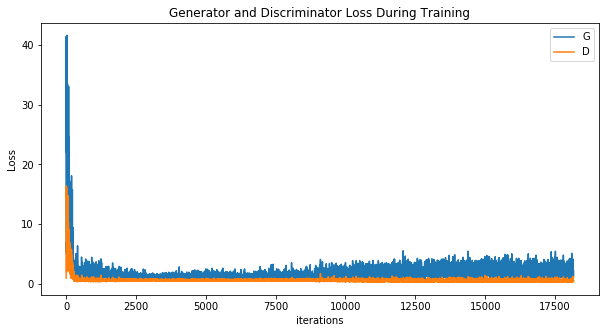

In [419]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

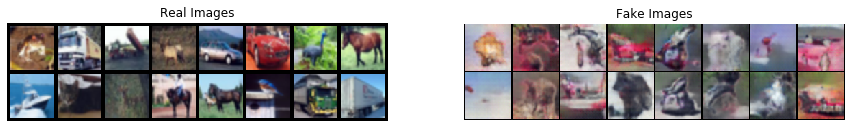

In [420]:
real_batch = next(iter(trainLoader))

noise = torch.randn(batchSize, nz, 1, 1, device=device)
fake = gen(noise).detach().cpu()
fake = vutils.make_grid(fake, padding=2, normalize=True)

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fake,(1,2,0)))
plt.show()

In [421]:
print(optimizerD, optimizerG, trainLoader.batch_size, ngf, ndf, real_label)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
) Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
) 16 128 128 0.8
